## Inferential Spatial Statistic using Geographically Weighted Regression (GWR) and Multi-scale Geographically Weighted Regression (MGWR) on Connecticut 'Stop and Search' Data

[Dr Zahratu Shabrina](www.linkedin.com/in/zahratu-shabrina)

### 1. Overview

This practical is intended to explore the use of GWR and MGWR model using Stop and Search dataset from Connecticut.

In the first part of the practical, we will be dealing with data cleaning and basic statistic of our data. In the second part, exploratory data analysis is conducted for extracting meaningful information. The third part is the spatial inferential statistic using correlation and regression and we'll close with a detailed look at conducting the Geographically Weighted Regression and Multiscale Geographically Weighted Regression to derive local inference based on our model.

### 2. Learning outcomes

By the end of the practicals, you should be able to:
- Extract meaningful information regarding the nature of traffic stop and search in Connecticut, United States, using exploratory data analysis
- Do a correlation and regression especially the geographically weighted regression (GWR) and the multiscale geographically weighted regression (MGWR) to derive local statistic of a phenomena
- Create appropriate visualisations for your findings

### 3. Dataset

We are going to use the traffic stop data containing 60 Million Police Stops in the United States. We will focus here on **analysing stop and search cases in Connecticut**. You can download the dataset here, unzip and put it in your local server. 
- https://stacks.stanford.edu/file/druid:py883nd2578/CT-clean.csv.gz

In the United States, there are more than 50,000 traffic stops on a typical day. The potential number of data points for each stop is huge, from the demographics (age, race, gender) of the driver, to the location, time of day, stop reason, stop outcome, car model, and much more. Unfortunately, not every state makes this data available, and those that do often have different standards for which information is reported. Different counties and districts within each state can also be inconstant in how each traffic stop is recorded. So, in June 2017, a team of researchers at Stanford University collected and released an open-source data set of 60 million state police patrol stops from 20 states across the US. 

**In this tutorial, we will walk through how to analyse, visualise and make spatial inference on the Connecticut Stop and Search dataset using Python (mainly PySAL and Geopandas).** 

 The research team at Stanford has managed to gather traffic-stop data from twenty states and has worked to regularize the reporting standards for 11 fields.

- Stop Date
- Stop Time
- Stop Location
- Driver Race
- Driver Gender
- Driver Age
- Stop Reason
- Search Conducted
- Search Type
- Contraband Found
- Stop Outcome

Most states do not have data available for every field, but there is enough overlap between the data sets to provide a solid foundation for some very interesting analysis.

**Note**
If you're interested in the dataset for other states, please see the list below:
- https://stacks.stanford.edu/file/druid:py883nd2578/VT-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/MA-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/WI-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/AZ-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/CO-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/NC-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/WA-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/TX-clean.csv.gz

### 4. Data cleaning

Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import geopandas as gp
import pandas as pd
from descartes import PolygonPatch
from pysal.model import mgwr
import pysal.lib
import libpysal as ps
from libpysal.weights.contiguity import Queen
# conda install mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

In [2]:
# Load the dataset and read using pandas, change to your own local path
df_ct = pd.read_csv('/Users/zarashabrina/projects/gwr-mgwr-tutorial-stopsearch/Connecticut Data/CT-clean.csv',low_memory=False)
df_ct.head()

,id,state,stop_date,stop_time,Location_Raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration
0,CT-2013-00062,CT,01/10/2013,01:39,Andover,Tolland County,9013.0,rt 6 rt 316,State Police,M,...,Other,Other,False,NaN,NaN,False,Ticket,False,1000002599,1-15 min
1,CT-2013-00636,CT,02/10/2013,02:49,Andover,Tolland County,9013.0,rt 6 rt 316,State Police,M,...,Other,Other,False,NaN,NaN,False,Ticket,False,1000002599,1-15 min
2,CT-2013-00736,CT,02/10/2013,08:56,Andover,Tolland County,9013.0,rt 6 wb at post office,State Police,F,...,Cell Phone,Cell phone,False,NaN,NaN,False,Written Warning,False,983347482,1-15 min
3,CT-2013-00765,CT,02/10/2013,09:28,Andover,Tolland County,9013.0,Rte 6 at shoddy mill rd,State Police,F,...,Speed Related,Speeding,False,NaN,NaN,False,Ticket,False,983347482,1-15 min
4,CT-2013-00913,CT,02/10/2013,13:13,Andover,Tolland County,9013.0,"RT 6 and RT 316, Andover",State Police,F,...,Cell Phone,Cell phone,False,NaN,NaN,False,Ticket,False,627195004,1-15 min


In [3]:
# Later on, we are going to analyse the traffic stop and search
# Let's add some socio-economic data for Connecticut
df_ct_soc = pd.read_csv('/Users/zarashabrina/projects/gwr-mgwr-tutorial-stopsearch/Connecticut Data/CT socio economic.csv',low_memory=False)
df_ct_soc.head()

,Town,Median_household_income,Median_rent,Crime_index,X,Y
0,Andover,97426,840,8,41.732982,-72.374658
1,Ansonia,43144,1026,378,41.344249,-73.069825
2,Ashford,77250,920,30,41.897123,-72.171427
3,Avon,116565,1404,168,41.787159,-72.852046
4,Barkhamsted,81792,1121,12,41.935708,-72.972921


In [4]:
# Can you list the available fields by reading the columns property?
df_ct.columns

Index(['id', 'state', 'stop_date', 'stop_time', 'Location_Raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome',
       'is_arrested', 'officer_id', 'stop_duration'],
      dtype='object')

Let's look out the count of our data. However our search_type_raw and search_type has lots of missing data. So let's drop those for better analysis.

In [5]:
# Checking the count of our data
df_ct.count()

id                       318669
state                    318669
stop_date                318669
stop_time                318447
Location_Raw             318628
county_name              318627
county_fips              318627
fine_grained_location    317006
police_department        318669
driver_gender            318669
driver_age_raw           318669
driver_age               318395
driver_race_raw          318669
driver_race              318669
violation_raw            318669
violation                318669
search_conducted         318669
search_type_raw            4846
search_type                4846
contraband_found         318669
stop_outcome             313313
is_arrested              313313
officer_id               318669
stop_duration            318669
dtype: int64

In [6]:
# Fill missing search type values with placeholder
df_ct['search_type'].fillna('N/A', inplace=True)
df_ct['search_type_raw'].fillna('N/A', inplace=True)

In [7]:
# Write your own code to delete the rows with missing values
df_ct.dropna(inplace=True)

Upon checking the data after dropping the row with missing values, we have a more consistent dataset with similar counts for each variable.

In [8]:
# Re-check our count data after we drop the rows with missing values
df_ct.count()

id                       311308
state                    311308
stop_date                311308
stop_time                311308
Location_Raw             311308
county_name              311308
county_fips              311308
fine_grained_location    311308
police_department        311308
driver_gender            311308
driver_age_raw           311308
driver_age               311308
driver_race_raw          311308
driver_race              311308
violation_raw            311308
violation                311308
search_conducted         311308
search_type_raw          311308
search_type              311308
contraband_found         311308
stop_outcome             311308
is_arrested              311308
officer_id               311308
stop_duration            311308
dtype: int64

We can continue on investigating our data and make sense of our data distribution by checking the count of each variable.

In [9]:
# Count the data based on the town's name
df_ct['Location_Raw'].value_counts()

Mansfield        8362
Killingly        7997
Danbury          7724
Tolland          6703
Hartford         6473
                 ... 
Wilton              4
Washighton          3
Falls Village       1
Griwold             1
Uncasville          1
Name: Location_Raw, Length: 176, dtype: int64

In [10]:
# Count the data based on whether or not search is conducted
df_ct['search_conducted'].value_counts()

False    306061
True       5247
Name: search_conducted, dtype: int64

In [11]:
# Count the data based on violation
df_ct['violation'].value_counts()

Speeding                                   99167
Other                                      85309
Registration/plates                        36515
Moving violation                           27339
Cell phone                                 19809
                                           ...  
Cell phone,Moving violation,Seat belt          1
Lights,Registration/plates,Speeding            1
Equipment,Moving violation,Other               1
Seat belt,Stop sign/light                      1
Equipment,Registration/plates,Seat belt        1
Name: violation, Length: 125, dtype: int64

The downside of the data set is that there is no agreed standard of violation classification, thus we see here there are many duplicates in terms of the classification. To avoid too much repetition, let's just cut the type of violation where value count is less than 1000 for simplicity purposes.

In [12]:
value_counts = df_ct['violation'].value_counts()

# Write your code to simplify our data and remove the values where the count is less than 1000
to_remove = value_counts[value_counts <= 1000].index

# Keep rows where the city column is not in to_remove
df_ct = df_ct[~df_ct.violation.isin(to_remove)]

In [13]:
df_ct['violation'].value_counts()

Speeding               99167
Other                  85309
Registration/plates    36515
Moving violation       27339
Cell phone             19809
Seat belt              11836
Lights                 11800
Stop sign/light         6997
Safe movement           4942
Equipment               2780
License                 2626
Name: violation, dtype: int64

In [14]:
df_ct['stop_outcome'].value_counts()

Ticket             216475
Verbal Warning      47155
Written Warning     26630
Summons             11687
Arrest               7173
Name: stop_outcome, dtype: int64

In [15]:
# Count the data based on the driver's gender and race
df_ct['driver_gender'].value_counts()

M    205214
F    103906
Name: driver_gender, dtype: int64

In [16]:
# Count the data based on the driver's gender and race
df_ct['driver_race'].value_counts()

White       234935
Black        36408
Hispanic     30216
Asian         5854
Other         1707
Name: driver_race, dtype: int64

Great, now our data is ready fof further investigation. In the next section, we will extract more information based on our data. Firstly, we are going to try to investigate if racial bias occurs in Connecticut stop and search by examining if certain race is being stopped more frequently than others, and how many of those stops end up in arrests. Secondly, we're going to calculate the hit rate, if a search ends up in contrabands found. 

### 5. Exploratory spatial data analysis

There are three things that we are going to do in this section:
1. We will see which race and in what age a driver is more likely to be stopped in traffic by the police.
2. We will examine the outcome of the stop and search based on the race and the reason the driver is being stopped, and see if the stop and search results in arrests.
3. We will explore whether a stop leads to a search and the rate in which contrabands are found.

Ok, let's start.

### 5.1 which race and in what age a driver is more likely to be stopped in traffic by the police?

In this subsection, we will examine if racial biased is indeed present when a police in Conneticut stops a driver by calculating the density of stop and search based on driver's age and race. 

In [17]:
# Include all the race except for 'other'
df_ct1 = df_ct[df_ct['driver_race'] != 'Other']

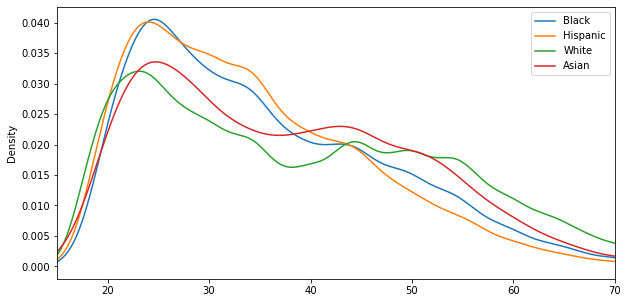

In [18]:
# Plot the graph of driver race and age against the density of stop and search
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim(15, 70)
for race in df_ct1['driver_race'].unique():
    s = df_ct1[df_ct1['driver_race'] == race]['driver_age']
    s.plot.kde(ax=ax, label=race)
ax.legend()

What information can you derive from the plot? We can see from all race, a driver between the age of 20 and 30 is more likely to be stopped in traffic for a stop and search by the police. This number drops with age. Black and Hispanic rate have higher stop and search density compared to their Asian and White peer.

### 5.2 Stop and search outcome analysis

When stopping a driver, a stop and search can result in different outcomes including verbal and written warnings, summons, as well as arrests. We can compute the rate of these outcomes by building this function below:

In [19]:
def outcome_stats(df):
    """Compute statistics regarding the relative quanties of arrests, warnings, and citations"""
    n_total = len(df)
    n_verbal_warnings = len(df[df['stop_outcome'] == 'Verbal Warning'])
    n_written_warnings = len(df[df['stop_outcome'] == 'Written Warning'])
    n_summons = len(df[df['stop_outcome'] == 'Summons'])
    n_arrests = len(df[df['stop_outcome'] == 'Arrest'])
    arrest_rate = n_arrests / n_total
    
    return(pd.Series(data = { 
        'n_total': n_total,
        'n_verbal_warnings': n_verbal_warnings,
        'n_written_warnings': n_written_warnings,
        'n_summons' : n_summons,
        'n_arrests': n_arrests,
        'arrest_rate': arrest_rate
    }))

Can you count based on the function above, how many stop and search ends up in:
- verbal warnings
- written warnings
- summons
- arrests

Which one is the highest and lowest outcome?

In [20]:
# Statistics of stop and search outcome
outcome_stats(df_ct)

n_total               309120.000000
n_verbal_warnings      47155.000000
n_written_warnings     26630.000000
n_summons              11687.000000
n_arrests               7173.000000
arrest_rate                0.023205
dtype: float64

In [21]:
# We can also group the outcome based on the driver race and violation
df_ct.groupby(['driver_race','violation']).apply(outcome_stats)

n_total  n_verbal_warnings  \
driver_race violation                                         
Asian       Cell phone             205.0               22.0   
            Equipment               19.0                5.0   
            License                 14.0                0.0   
            Lights                 140.0               66.0   
            Moving violation       569.0              168.0   
            Other                 1680.0               92.0   
            Registration/plates    337.0               35.0   
            Safe movement          101.0               15.0   
            Seat belt               78.0                5.0   
            Speeding              2578.0              168.0   
            Stop sign/light        133.0               22.0   
Black       Cell phone            1192.0              140.0   
            Equipment              493.0              163.0   
            License                543.0               12.0   
            Lights                1320.0              532.0   
            Moving violation      3938.0             1199.0   
            Other                 9829.0              921.0   
            Registration/plates   4511.0              713.0   
            Safe movement          480.0               98.0   
            Seat belt             1387.0              111.0   
            Speeding             12436.0             1347.0   
            Stop sign/light        279.0               68.0   
Hispanic    Cell phone            1461.0              115.0   
            Equipment              523.0              181.0   
            License                399.0               11.0   
            Lights                1030.0              397.0   
            Moving violation      2996.0              691.0   
            Other                 8708.0              610.0   
            Registration/plates   3760.0              449.0   
            Safe movement          441.0               56.0   
            Seat belt             1360.0               91.0   
            Speeding              9231.0              771.0   
            Stop sign/light        307.0               43.0   
Other       Cell phone              90.0               11.0   
            Equipment                9.0                6.0   
            License                  3.0                1.0   
            Lights                  63.0               33.0   
            Moving violation       187.0               66.0   
            Other                  506.0               49.0   
            Registration/plates    126.0               27.0   
            Safe movement           30.0               10.0   
            Seat belt               33.0                3.0   
            Speeding               633.0               61.0   
            Stop sign/light         27.0                9.0   
White       Cell phone           16861.0             1979.0   
            Equipment             1736.0              633.0   
            License               1667.0               53.0   
            Lights                9247.0             4314.0   
            Moving violation     19649.0             5983.0   
            Other                64586.0             6584.0   
            Registration/plates  27781.0             4271.0   
            Safe movement         3890.0              801.0   
            Seat belt             8978.0              941.0   
            Speeding             74289.0            10646.0   
            Stop sign/light       6251.0             1357.0   

                                 n_written_warnings  n_summons  n_arrests  \
driver_race violation                                                       
Asian       Cell phone                         10.0        0.0        3.0   
            Equipment                           3.0        0.0        0.0   
            License                             0.0       11.0        1.0   
            Lights                             31.0     

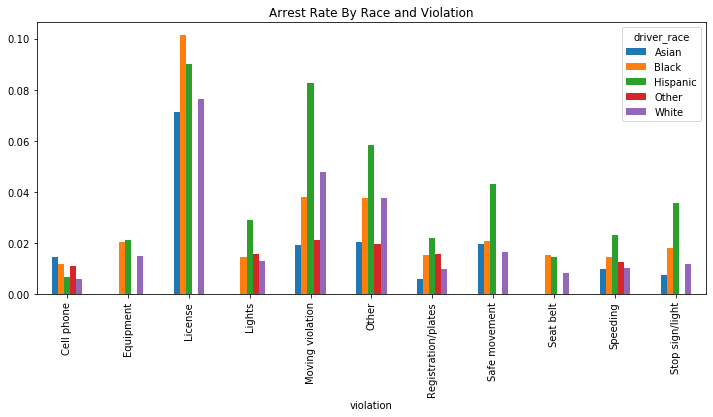

In [22]:
# Let's visualise the violation based on the driver's race and see how many of these result in arrests
race_stats = df_ct.groupby(['violation', 'driver_race']).apply(outcome_stats).unstack()
race_stats.plot.bar(y='arrest_rate', title='Arrest Rate By Race and Violation', figsize=(12,5))

Based on the graph, the Black race has the highest rate of arrests (0.10) and they are most likely to be stopped due to license check instead of other traffic violations. This is followed by Hispanic with 0.09 arrests rate when stopped for license check.

So, do you think racial bias is present according to our dataset?

### 5.3 Stop and search hit rate

When stopping a driver, police can conduct a search, and some of this search lead to contrabands found (hit). We can examine the proportion of searches that result in contrabands found by building this function below:

In [23]:
def search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['search_conducted']
    contraband_found = df['contraband_found']
    n_stops     = len(search_conducted)
    n_searches  = sum(search_conducted)
    n_hits      = sum(contraband_found)
    
    # Filter out counties with too few stops
    if (n_stops) < 50:
        search_rate = None
    else:
        search_rate = n_searches / n_stops
    
    # Filter out counties with too few searches
    if (n_searches) < 5:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches
    
    return(pd.Series(data = { 
        'n_stops': n_stops,
        'n_searches': n_searches,
        'n_hits': n_hits,
        'search_rate': search_rate,
        'hit_rate': hit_rate
    }))

In [24]:
# Let's get the search and hit rates
search_stats(df_ct)

n_stops        309120.000000
n_searches       5187.000000
n_hits           1770.000000
search_rate         0.016780
hit_rate            0.341238
dtype: float64

In [25]:
# Write your code here to group the search and hit rates according to the driver's race
df_ct.groupby('driver_race').apply(search_stats)

,n_stops,n_searches,n_hits,search_rate,hit_rate
driver_race,,,,,
Asian,5854.0,25.0,10.0,0.004271,0.400000
Black,36408.0,1190.0,339.0,0.032685,0.284874
Hispanic,30216.0,933.0,271.0,0.030878,0.290461
Other,1707.0,13.0,0.0,0.007616,0.000000
White,234935.0,3026.0,1150.0,0.012880,0.380040


In [26]:
# Get the outcome stats per-town in connecticut
town_stop_search = df_ct.groupby(['Location_Raw']).apply(outcome_stats)
town_stop_search.head()

,n_total,n_verbal_warnings,n_written_warnings,n_summons,n_arrests,arrest_rate
Location_Raw,,,,,,
Andover,1086.0,169.0,48.0,27.0,14.0,0.012891
Ansonia,169.0,41.0,8.0,5.0,5.0,0.029586
Ashford,1217.0,177.0,112.0,30.0,22.0,0.018077
Avon,23.0,7.0,6.0,1.0,0.0,0.000000
Barkhamsted,745.0,59.0,282.0,60.0,13.0,0.017450


What is your conclusion based on these findings?

### 6. Spatial inferential statistic

For our spatial inferential statistic, we will examine the stop and search data against the socio-economic dataset from Connecticut open data website. Three variables are chosen in particular: median household income, median house rent price and crime index data. We will try to make inferences of the relationship between the socio-economic data and the stop and search dataset. 

In [27]:
# First, let's merge our two dataset using pandas merge function based on the same column values (Town and Location_Ra)
gwr_data = pd.merge(df_ct_soc, town_stop_search, left_on='Town', right_on='Location_Raw')
gwr_data.dropna(inplace=True)
gwr_data.head()

,Town,Median_household_income,Median_rent,Crime_index,X,Y,n_total,n_verbal_warnings,n_written_warnings,n_summons,n_arrests,arrest_rate
0,Andover,97426,840,8,41.732982,-72.374658,1086.0,169.0,48.0,27.0,14.0,0.012891
1,Ansonia,43144,1026,378,41.344249,-73.069825,169.0,41.0,8.0,5.0,5.0,0.029586
2,Ashford,77250,920,30,41.897123,-72.171427,1217.0,177.0,112.0,30.0,22.0,0.018077
3,Avon,116565,1404,168,41.787159,-72.852046,23.0,7.0,6.0,1.0,0.0,0.000000
4,Barkhamsted,81792,1121,12,41.935708,-72.972921,745.0,59.0,282.0,60.0,13.0,0.017450


### 6.1 Correlation

A correlation matrix is a table showing correlation coefficients between variables used to summarize data. The correlation coeffiecient (r) indicates association, where +1 is perfect positive relationship and -1 is perfect negative relationship. It is useful to examine the relationships between variables fairly quickly.

Pandas *dataframe.corr()* is used to find the pairwise correlation of all columns in the dataframe. Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.

In [28]:
# Creating a correlation matrix
data = gwr_data.drop(['X','Y'], axis=1)
corr= data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Median_household_income,Median_rent,Crime_index,n_total,n_verbal_warnings,n_written_warnings,n_summons,n_arrests,arrest_rate
Median_household_income,1,0.306668,-0.234688,-0.222862,-0.216602,-0.137232,-0.318923,-0.227665,-0.104378
Median_rent,0.306668,1,0.0170163,0.0242594,0.00381247,-0.137511,-0.0208562,0.0135697,-0.0540275
Crime_index,-0.234688,0.0170163,1,0.259126,0.157921,-0.0178866,0.431191,0.313519,0.0175802
n_total,-0.222862,0.0242594,0.259126,1,0.855594,0.585193,0.809491,0.860532,-0.115608
n_verbal_warnings,-0.216602,0.00381247,0.157921,0.855594,1,0.581581,0.801417,0.820499,-0.0433814
n_written_warnings,-0.137232,-0.137511,-0.0178866,0.585193,0.581581,1,0.435593,0.540219,-0.0638535
n_summons,-0.318923,-0.0208562,0.431191,0.809491,0.801417,0.435593,1,0.8638,0.0197215
n_arrests,-0.227665,0.0135697,0.313519,0.860532,0.820499,0.540219,0.8638,1,0.150389
arrest_rate,-0.104378,-0.0540275,0.0175802,-0.115608,-0.0433814,-0.0638535,0.0197215,0.150389,1


In spatial analysis workflows it is often important and necessary to asses the relationships of neighbouring polygons. libpysal and splot can help you to inspect if two neighbouring polygons share an edge or not. This visualisation depicts the spatial weights network, a network of connections of the centroid of each polygon to the centroid of its neighbour. 

We can start to see the positive and negative associations between variables. For example, crime index has 0.2 negative association with household income where higher income in an area is associated with lower crime. This makes sense.

***Can you examine the relationship between crime index and total stop and search? why this might be?***

We have learned that in spatial analysis, we often need to make spatial inferences locally where the global model is not suitable. Here, we will explore local model to explain stop and search phenomena. Let's start with conducting OLS and the geographically weighted regression for Connecticut township to determine if number of arrests from stop and search is associated with the socio economic profile of each township.

### 6.2 Regression: Ordinary Least Squares (Global Model) and Geographically Weighted Regression - GWR (Local Model)
Simple linear regression, the most used technique in geographical analysis, assumes changes across space to be universal, which is not always the case in the spatial context. Variations across geographical space, known as spatial non-stationarity, might be lost when using simple global fitting methods such as Ordinary Least Squares (OLS). Therefore, geographically weighted regression (GWR), provides an alternative method to analyse and model the complex spatial variations in local parameter estimates. The developed method extends the traditional linear regression technique to incorporate spatial heterogeneity in different regions by allowing the parameter estimate to vary locally.

In this section, we will compare the summary statistic as a result of the global OLS (Ordinary Least Squares) model and the Geographically Weighted Regression.

### 6.2.1 Ordinary Least Squares (OLS)

In last week's practical, you learned how to do an OLS regression using PySAL. Can you try it again using our data?

In [29]:
# First, you need to prepare the dataset so it can be processed in pysal
crime = gwr_data['Crime_index']
# OLS class requires data to be passed as numpy array
y = np.array(crime)
# PySAL requires your dependent variable to be nx1 numpy array
y.shape = (len(crime),1)

In [30]:
# Now prepare your independent variables
X = []
X.append(gwr_data['Median_household_income'])
X.append(gwr_data['Median_rent'])
X.append(gwr_data['n_total'])
X.append(gwr_data['n_arrests'])
# PySAL requires your independent variable to be a 2D nxj numpy array where j is the number of independent variables
X=np.array(X).T

In [31]:
# Check if your independent variables are in the right format
print(X.shape)

(166, 4)


In [32]:
# OLS regression
ols = pysal.model.spreg.OLS(y, X, name_y='Crime Index',\
          name_x=['Median Income','Median rent','Total Stop Search', 'Total SS Arrests'],\
          name_ds='Connecticut', white_test=True)
print(ols.summary)
                        

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : Connecticut
Weights matrix      :        None
Dependent Variable  : Crime Index                Number of Observations:         166
Mean dependent var  :    842.9337                Number of Variables   :           5
S.D. dependent var  :   3459.4265                Degrees of Freedom    :         161
R-squared           :      0.1324
Adjusted R-squared  :      0.1108
Sum squared residual:1713233026.061                F-statistic           :      6.1418
Sigma-square        :10641198.920                Prob(F-statistic)     :   0.0001264
S.E. of regression  :    3262.085                Log likelihood        :   -1575.966
Sigma-square ML     :10320680.880                Akaike info criterion :    3161.931
S.E of regression ML:   3212.5817                Schwarz criterion     :    3177.491

---------------------------------------------------------------------------

### 6.2.2 Geographically Weighted Regression (GWR)

Now, let's try and compare the results of our OLS with GWR model. The summary of GWR model will also contain OLS automatically, but they are not as comprehensive as our previous one so it's good just to have more information.

In [33]:
#Prepare dataset inputs
g_y = gwr_data['Crime_index'].values.reshape((-1,1))
g_X = gwr_data[['Median_household_income', 'Median_rent', 'n_total', 'n_arrests']].values
u = gwr_data['X']
v = gwr_data['Y']
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [34]:
# Select bandwidth for kernel
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Independent variable
                  g_X, # Dependent variable
                  fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
                  spherical=True) # Spherical coordinates (long-lat) or projected coordinates

In [35]:
# Can you calculate the optimum bandwidth for our local regression?
bw.search()

54.0

#### Spatial weighting

Do you remember the concept of neighbours for spatial weighting from last week's practical? You do! Great! If not, go back and check :)

In Geographically Weighted Regression (GWR), we are still using the concept of neighbour, where we need to find the optimal bandwidth (in our case, we specified k nearest neighbours) where nearer neighbours are assigned heavier weightings than distanced ones.

Neighbours can be defined using the concept of neighbourhood relations and there are several types of contiguity (bordering) including 
- the Rook Case (share edges), 
- the Bishop Case (share corners/nodes), 
- the Queen Case (share edges or corners) and 
- the secondary order contiguity (neighbour of neighbour).

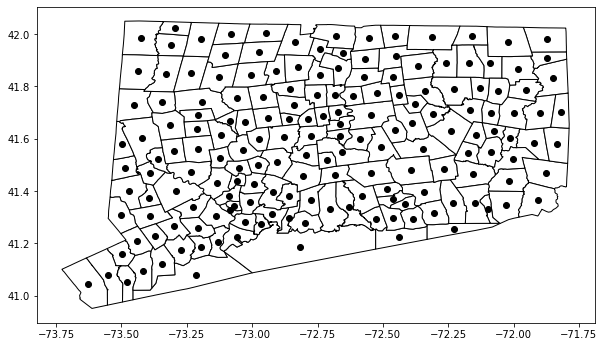

In [36]:
# Read in Connecticut shapefile using geopandas
ct_shp = gp.read_file('Connecticut Data/CT_Town.shp')
fig, ax = plt.subplots(figsize=(10,10))
ct_shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})

# Plot centroids for each county
ct_shp.centroid.plot(ax=ax, c='black')
plt.show()

In [37]:
# Calculating neighbours based on the Queen's contiguity
wq = Queen.from_dataframe(ct_shp)
wq

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1289e1c88>)

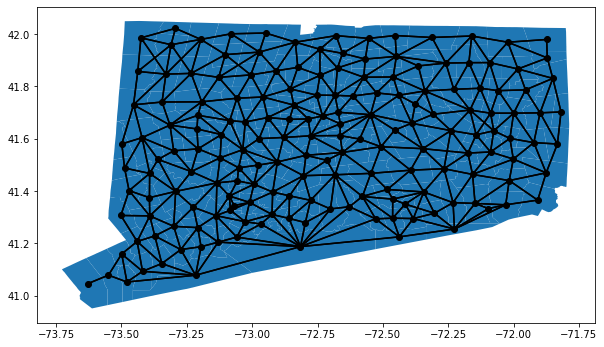

In [38]:
# Calculating neighbours based on the Queen's contiguity
wq = Queen.from_dataframe(ct_shp)
#centroids = np.array([list(poly.centroid) for poly in ct_shp.geometry])

# Now we can visualise the weights in the map
f, ax = plt.subplots(1,1, figsize=(10,10))
ct_shp.plot(ax=ax)
wq.plot(ct_shp, ax=ax)

When visualised, neighbours can be visualised such as those in the figure above.

Let's go on and continue constructing our model.

In [39]:
# Building the Geographically Weighted Regression Model
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

In [40]:
# Fit the model with particular estimations 
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 166
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            144.023
Log-likelihood:                                                    -223.757
AIC:                                                                457.513
AICc:                                                               460.042
BIC:                                                               -679.007
R2:                                                                   0.132
Adj. R2:                                                              0.111

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

**How good is the model? Can you compare the two models?**

The results summary contains the summary statistic of both the global model (using OLS) - top part; and the Geographically Weighted Regression results - bottom part.

To check the goodness of fit of the model, we can compare these values:

- The residual sum of squares (RSS), indicating unexplained variations, **lower RSS indicates better model fit**
- corrected Akaike Information Criterion (AICc): representing the relative amount of lost information in the model by considering both the risk of overfitting and underfitting, **lower AICc indicates better model fit**
- The adjusted $R^2$ indicates the level of model variance that can be captured by the model, **higher adjusted $R^2$ indicates better model fit**

In [41]:
# We can check the shape of our local parameters array
print(results.params.shape)

(166, 5)


In [42]:
type(results.params)

numpy.ndarray

From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we **only include statistically significant estimates** (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using *filter_tval*.

In [43]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### 6.4 Visualising the GWR results

To make it easier on reading the results of our model, we will build a new dataframe containing the information of the model's parameter estimates and local R2 in Connecticut Towns.

In [44]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [45]:
# Create the new dataframe
df1=pd.DataFrame(gwr_data["Town"])
df2 = df1.assign(intercept=data_params[0],
                 Med_income_estimate=data_params[1],
                 Med_rent_estimate=data_params[2],
                 total_stop_search_estimate=data_params[3],
                 total_ss_arrests=data_params[4],
                 localR2=data_localR2[0])
df2.columns
df2

,Town,intercept,Med_income_estimate,Med_rent_estimate,total_stop_search_estimate,total_ss_arrests,localR2
0,Andover,0.000000,0.0,0.000000,0.0,0.000000,-0.786738
1,Ansonia,0.000000,0.0,0.000000,0.0,0.000000,0.596445
2,Ashford,0.000000,0.0,0.000000,0.0,0.000000,-0.724248
3,Avon,0.000000,0.0,0.000000,0.0,4.480764,0.595410
4,Barkhamsted,3.127313,0.0,0.000000,0.0,6.354661,0.773314
...,...,...,...,...,...,...,...
161,Windsor,0.000000,0.0,0.000000,0.0,4.072186,0.611670
162,Windsor Locks,0.000000,0.0,2.641024,0.0,0.000000,0.229291
163,Wolcott,0.000000,0.0,0.000000,0.0,0.000000,0.418441
164,Woodbridge,0.000000,0.0,0.000000,0.0,0.000000,0.024386


We can merge the results of our MGWR model and our shapefile using merge function

In [46]:
# Merge our shapefile with the model's results
ct_shp = ct_shp.merge(df2, left_on='NAME10', right_on='Town')
ct_shp.head()

,STATEFP10,COUNTYFP10,COUSUBFP10,COUSUBNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,...,GEOID_AFF2,GEOID_AFF1,geometry,Town,intercept,Med_income_estimate,Med_rent_estimate,total_stop_search_estimate,total_ss_arrests,localR2
0,09,001,04720,00213390,0900104720,Bethel,Bethel town,43,T1,G4040,...,0600000US0900104720,06000US0900104720,"POLYGON ((-73.43371 41.36737, -73.43423 41.368...",Bethel,0.0,0.0,0.0,0.0,0.0,0.520187
1,09,001,08070,00213396,0900108070,Bridgeport,Bridgeport town,43,T5,G4040,...,0600000US0900108070,06000US0900108070,"POLYGON ((-73.23338 41.14300, -73.23361 41.143...",Bridgeport,0.0,0.0,0.0,0.0,0.0,0.734032
2,09,001,08980,00213399,0900108980,Brookfield,Brookfield town,43,T1,G4040,...,0600000US0900108980,06000US0900108980,"POLYGON ((-73.42154 41.44794, -73.42258 41.451...",Brookfield,0.0,0.0,0.0,0.0,0.0,0.404112
3,09,001,18500,00213415,0900118500,Danbury,Danbury town,43,T5,G4040,...,0600000US0900118500,06000US0900118500,"POLYGON ((-73.42378 41.45487, -73.42294 41.452...",Danbury,0.0,0.0,0.0,0.0,0.0,0.651629
4,09,001,18850,00213416,0900118850,Darien,Darien town,43,T1,G4040,...,0600000US0900118850,06000US0900118850,"POLYGON ((-73.50910 41.06574, -73.50910 41.065...",Darien,0.0,0.0,0.0,0.0,0.0,0.519245


Let's visualise the GWR results

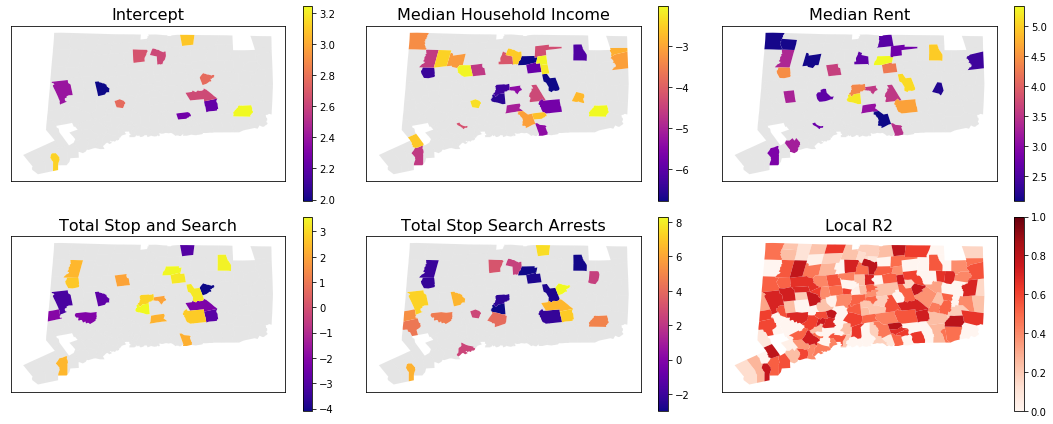

In [47]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','Median Household Income', 'Median Rent', 'Total Stop and Search', 'Total Stop Search Arrests']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    ct_temp = ct_shp.assign(toplot=filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 
# For the last one, local R2, we can just map all of them regarding the significance

(ct_shp.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()
    

### 6.5 Taking it further - Building MGWR Model
MGWR recasts GWR as a generalised additive model (GAM) and uses a back fitting algorithm. This refers to the iterative process of calibrating a series of GWR models based on the models' partial residuals until the MGWR model converges to a solution. In other words, the algorithm allows us to update each iteration process using an appropriate smoothing function by refining the partial residuals. Taylor Oshan (2018) argues that an MGWR needs to be initialised using a starting value (generally the optimum parameter estimates based on the GWR model) for faster model calibration. Here, we will be using MGWR library, as we have already define our coordinate, y and x, let's just reuse them.

In [48]:
#Calibrate GWR model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

44.0


In [49]:
#Calibrate MGWR model

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

[103.  20. 107. 165.  39.]


In [50]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 166
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            144.023
Log-likelihood:                                                    -223.757
AIC:                                                                457.513
AICc:                                                               460.042
BIC:                                                               -679.007
R2:                                                                   0.132
Adj. R2:                                                              0.111

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## 6.6 Extras
**Can you see the differences between GWR and MGWR results? Try visualise them and write your conclusion**

## Takeaways

Spatial heterogeneity is often lost in OLS, thus a more robust model is needed. The GWR and MGWR model often improves models performance in spatial cases, by allowing local variations to be captured.

## Congratulation in completing this practical!! :)


## Credit

The dataset and the first part of the data cleaning and preparation is modified and adapted from https://github.com/triestpa/Police-Analysis-Python and the code in their project is 100% open source (MIT license).

The function to create the GWR maps is adapted from https://methods.sagepub.com/dataset/howtoguide/geographically-weighted-regression-berlin-districts-2018-python

The MGWR complete tutorial can be found here https://github.com/pysal/mgwr/blob/master/notebooks/MGWR_Georgia_example.ipynb

## References

Arribas-bel, Dani. Geographic Data Science with PySAL and the pydata stack. Available at  http://darribas.org/gds_scipy16/ipynb_md/05_spatial_dynamics.html

Brunsdon, C., Fotheringham, A. S., & Charlton, M. E. (1996). Geographically weighted regression: a method for exploring spatial nonstationarity. *Geographical analysis*, 28(4), 281-298.

Fotheringham, A. S., Brunsdon, C., & Charlton, M. (2003). Geographically weighted regression: the analysis of spatially varying relationships. John Wiley & Sons.
